# About this notebook

In this notebook we use some spatial techniques to predict the amount of lead in the soil of the riverbank Meuse in the Netherlands. This is one of the textbook examples in Spatial statistics.

In [2]:
import os
import requests
import zipfile
import geopandas as gpd
import shapely
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import folium
from folium import plugins
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sb
from IPython.core.display import HTML
from scipy.spatial import distance_matrix
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

HTML("<style>.container { width:100% !important; }</style>")

## Download and import the shapefile

- Download the zipfile from http://spatial-analyst.net/book/meusegrids
- Extract the zipfile
- Delete the zipfile

In [3]:
if(~os.path.isfile('meuse.zip')):
    url = 'http://spatial-analyst.net/book/system/files/meuse.zip'
    results = requests.get(url)
    print('Status code download: {}'.format(results.status_code))
with open('meuse.zip', 'wb') as f:
    f.write(results.content)
zip_ref = zipfile.ZipFile('meuse.zip', 'r')
zip_ref.extractall('meuse_example_data/')
zip_ref.close()
os.remove('meuse.zip')

Status code download: 200


In [4]:
meuse = gpd.read_file('meuse_example_data/meuse.shp', )
meuse.crs = 'epsg:28992'
meuse['x'] = meuse['geometry'].apply(lambda x: x.x)
meuse['y'] = meuse['geometry'].apply(lambda x: x.y)

meuse.sample()

,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,geometry,x,y
1,8.6,81.0,277.0,1141.0,6.983,0.012224,14.0,1,1,1,Ah,30.0,POINT (181025.000 333558.000),181025.0,333558.0


## What variables are in the dataset

- x = a numeric vector; x-coordinate (m) in RDM (Dutch topographical map coordinates)
- y = a numeric vector; y-coordinate (m) in RDM (Dutch topographical map coordinates)
- cadmium = topsoil cadmium concentration, ppm.; note that zero cadmium values in the original data set have been shifted to 0.2 (half the lowest non-zero value)
- copper = topsoil copper concentration, ppm.
- lead = topsoil lead concentration, ppm.
- zinc = topsoil zinc concentration, ppm.
- elev = relative elevation
- dist = distance to river Meuse; obtained from the nearest cell in meuse.grid, which in turn was derived by a spread (spatial distance) GIS operation, therefore it is accurate up to 20 metres; normalized $[0,1]$
- om = organic matter, as percentage
- ffreq = flooding frequency class
- soil = soil type
- lime = lime class
- landuse = landuse class
- dist.m = distance to river Meuse (metres), as obtained during the field survey

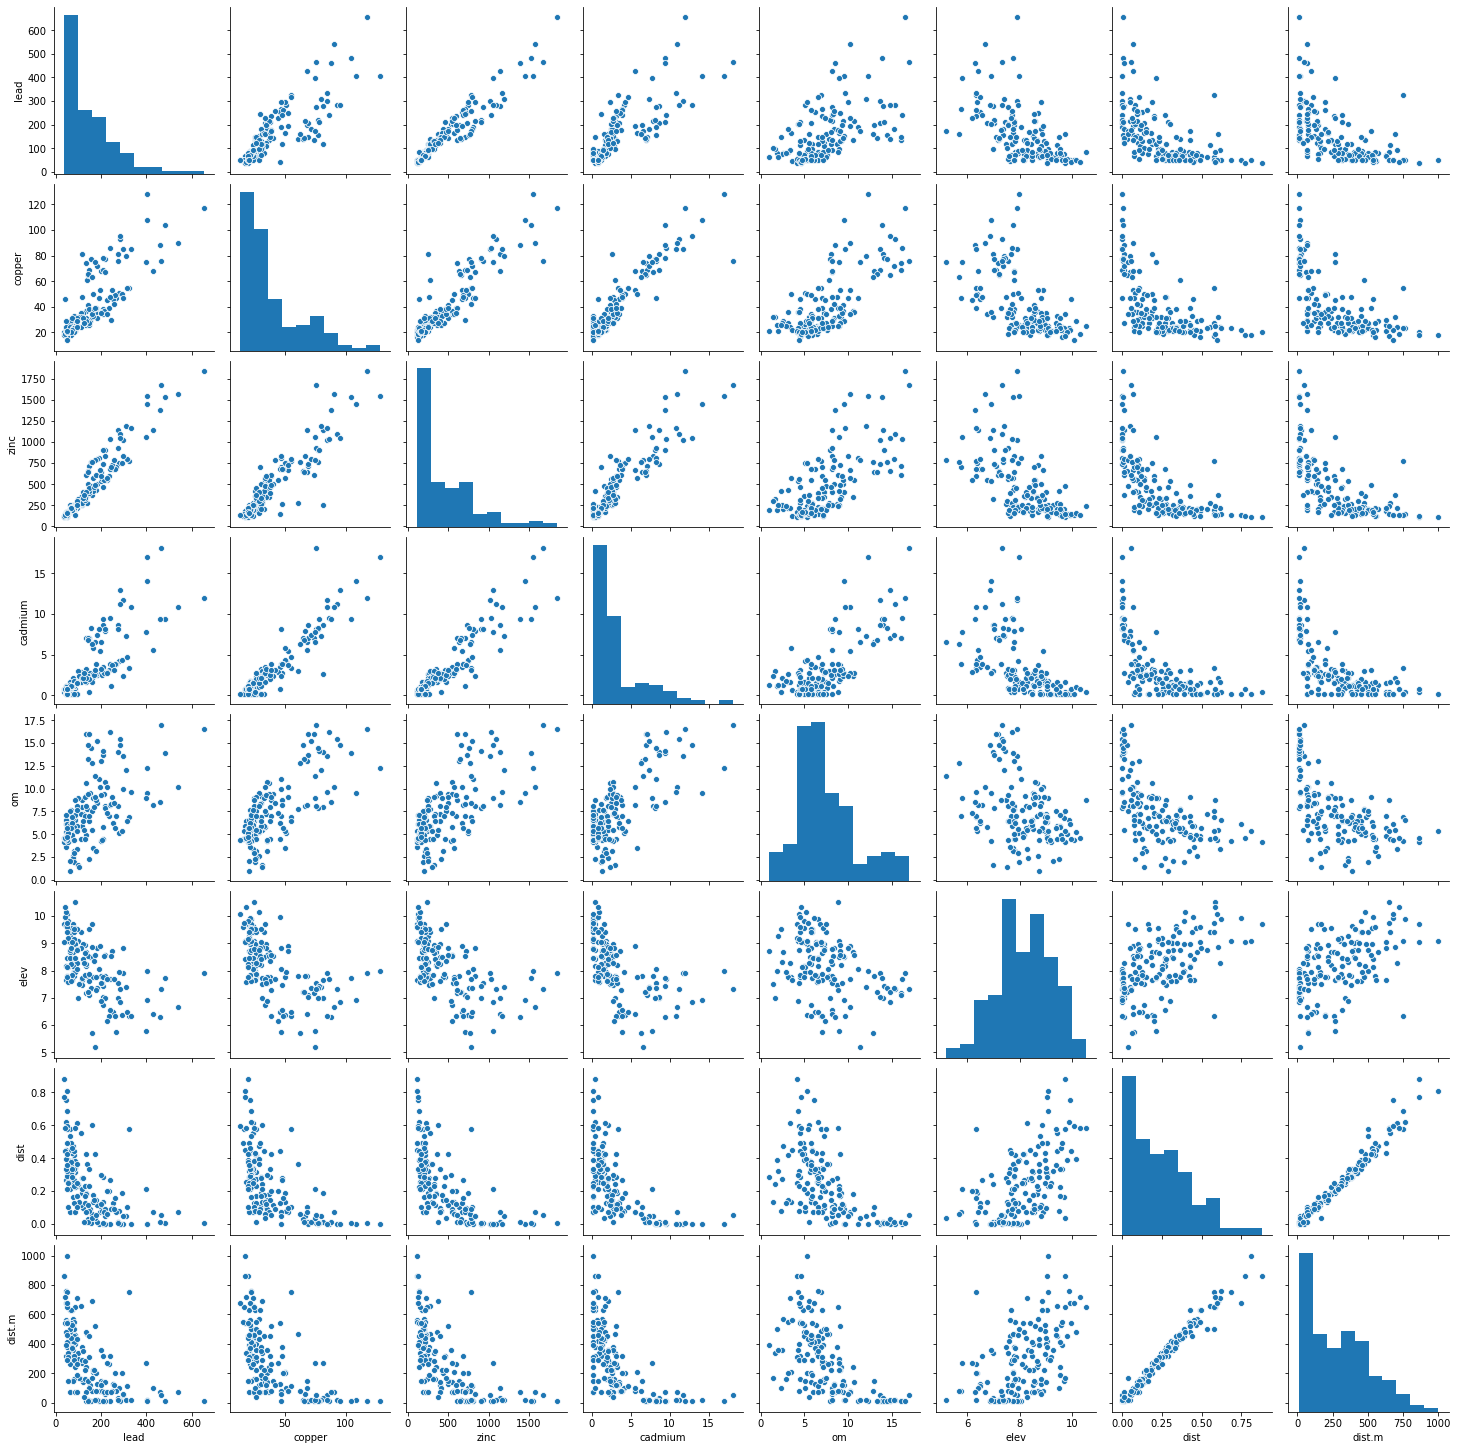

In [5]:
sb.pairplot(meuse[['lead', 'copper', 'zinc', 'cadmium', 'om', 'elev', 'dist', 'dist.m' ]])

## Spatial plots

#### Locations of measurements

- Plots with Folium works best with Lat/Long coordinates. These are spherical coordinates. The X/Y coordinates we have are from the original epsg:28992 projection system are carthesian coordinates (coordinates in a plane)

In [6]:
# Reproject back to sperical coordinates
meuse = meuse.to_crs('epsg:4326')
meuse['long'] = meuse.geometry.apply(lambda x: x.x)
meuse['lat'] = meuse.geometry.apply(lambda x: x.y)

In [7]:
# Initiate folium map and plot each measurement as a circle on it
m = folium.Map(location=[meuse['lat'].mean(), meuse['long'].mean()], zoom_start=13, tiles='Stamen Toner')

for i, row in meuse.iterrows():
    folium.CircleMarker(location=[row['lat'], row['long']], radius=1, color='dodgerblue', fill_opacity=1,
                    fill_color='dodgerblue').add_to(m)

m

#### Lead concentration at each measurement

- The color of each dot represents the lead concentration at each location. Use the colormap from Matplotlib for this


Text(0.5, 1.0, 'Color scale')

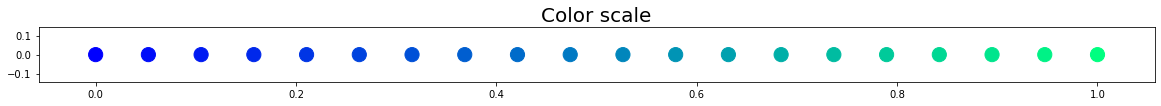

In [8]:
colormap = plt.get_cmap('winter')

x = np.linspace(0,1, 20)
color = colormap(x)

fig, ax = plt.subplots(1,1,figsize=(20,1))
ax.scatter(x=x, y=np.repeat(0, len(x)), c=color, s=200)
ax.set_title('Color scale', size=20)


In [9]:
minmax_transformer = MinMaxScaler()
meuse['lead_normalized'] = minmax_transformer.fit_transform(meuse[['lead']])
colormap = plt.get_cmap('winter')

m = folium.Map([meuse['lat'].mean(), meuse['long'].mean()], zoom_start=13, tiles='Stamen Toner', control_scale = True)

for i, row in meuse.iterrows():
    color_rgba = colormap(row['lead_normalized'])
    color_hex = matplotlib.colors.rgb2hex(color_rgba)
    folium.CircleMarker(location=[row['lat'], row['long']], 
                        radius=3, 
                        color=None, 
                        fill_opacity=1,
                        fill_color=color_hex).add_to(m)
m

#### Lead concentration seems skewed

- This is confirmed by a histogram

Text(0.5, 1.0, 'Lead concentration')

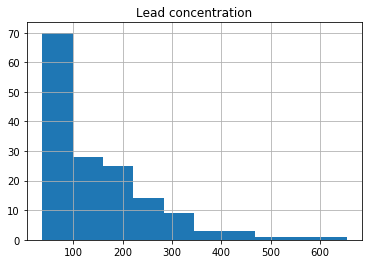

In [10]:
meuse['lead'].hist()
plt.title('Lead concentration')

## Spatial correlation

In [11]:
standard_scaler = StandardScaler()

meuse['lead_standardized'] = standard_scaler.fit_transform(meuse[['lead']])

Text(0.5, 1.0, 'Lead concentration standardized')

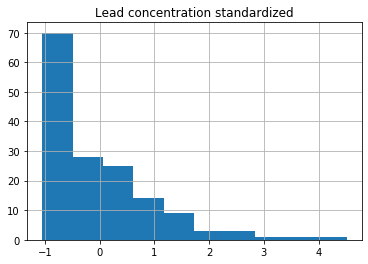

In [12]:
meuse['lead_standardized'].hist()
plt.title('Lead concentration standardized')

In [13]:
# Takes quite a while...
distances_measurements = distance_matrix(meuse[['x', 'y']], meuse[['x', 'y']])

variogram_data = []

for i, row_i in enumerate(distances_measurements):
    if(i%10==0): print(i)
    for j, distance in enumerate(distances_measurements[i]):
        #if(distance<0.01): continue
        #if(distance>15): continue
        diff_squared = np.power(meuse.iloc[i, :]['lead_standardized'] - meuse.iloc[j, :]['lead_standardized'],2)
        temp_dict = {'i': i, 'j':j, 'diff': diff_squared, 'distance': distance}
        variogram_data.append(temp_dict)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


Text(0, 0.5, 'Difference squared')

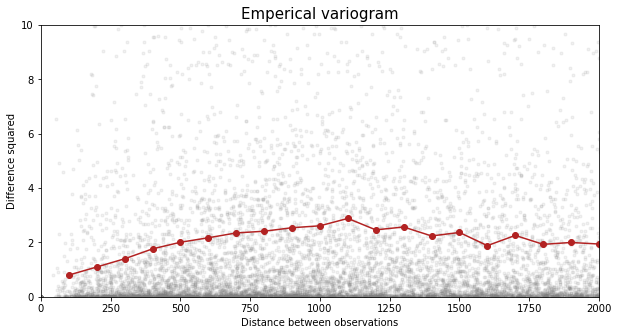

In [14]:
variogram_data = pd.DataFrame(variogram_data)
variogram_data['distance_rounded'] =  np.round(variogram_data['distance']/100)*100
difference_binned = variogram_data.groupby('distance_rounded')['diff'].mean()
difference_binned = difference_binned.iloc[1:]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(variogram_data['distance'], variogram_data['diff'], '.', alpha=0.05, color='grey')
ax.plot(difference_binned.index, difference_binned,  '-o', color='firebrick')
ax.set_ylim(0,10)
ax.set_xlim(0,2000)
ax.set_title('Emperical variogram', size=15)
ax.set_xlabel('Distance between observations')
ax.set_ylabel('Difference squared')


## Help functions to sample a grid from a polygon

As found on http://portolan.leaffan.net/creating-sample-points-with-ogr-and-shapely-pt-2-regular-grid-sampling/

In [15]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step


Sampled 2809 grid points


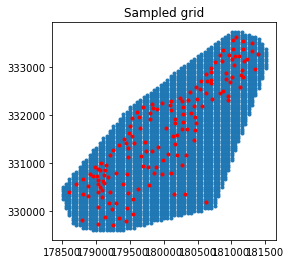

In [16]:
meuse = meuse.to_crs('epsg:28992')

convex_hull = shapely.geometry.MultiPoint(list(meuse.geometry)).convex_hull.buffer(150)
sampler = RegularGridSampler(convex_hull, x_interval=50, y_interval=50)
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(4,4))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(meuse['x'], meuse['y'], 'r.')
plt.title('Sampled grid')
print('Sampled {} grid points'.format(grid_points.shape[0]))

In [ ]:
from scipy.spatial import KDTree
# Intermezzo, estimate the distance to the meuse for each grid point, based on the distances in the measurements. 
# On locations where there is not a measurement closeby, this estimation is completely wrong
tree = KDTree(data=meuse[['x', 'y']])    
indexes = tree.query(grid_points[['x', 'y']])

grid_points['dist'] = meuse.iloc[indexes[1],:]['dist'].values

## Benchmark model: can we predict the lead concentration with a simple Gradient Boosting model?

{'n_estimators': 26}
R2 score with cross validation predictions: 0.057


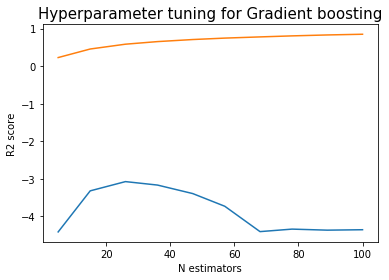

In [53]:
parameters = {'n_estimators':np.linspace(5,100,10, dtype=int )}

regressor = GradientBoostingRegressor(max_depth=2)
regressor_cv = GridSearchCV(regressor, parameters, cv=10, scoring='r2', return_train_score=True)
regressor_cv.fit(meuse[['x', 'y']], meuse['lead'])

cv_results = pd.DataFrame(regressor_cv.cv_results_)

plt.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], label='Test')
plt.plot(cv_results['param_n_estimators'], cv_results['mean_train_score'], label='Train')
plt.title('Hyperparameter tuning for Gradient boosting', size=15)
plt.ylabel('R2 score')
plt.xlabel('N estimators')

print(regressor_cv.best_params_)

meuse['gbm_predictions']  = cross_val_predict(X=meuse[['x', 'y']],
                                              y=meuse['lead'], estimator=regressor_cv.best_estimator_, cv=10)

print('R2 score with cross validation predictions: {:.3f}'.format(r2_score(meuse['lead'], meuse['gbm_predictions'])))



In [55]:
grid_points['gbm_prediction'] = regressor_cv.best_estimator_.predict(grid_points[['x', 'y']])
grid_points['gbm_prediction_normalized'] = minmax_transformer.transform(grid_points[['gbm_prediction']])

Text(0.5, 1.0, 'Kriged grid values')

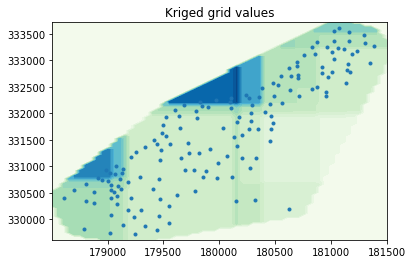

In [56]:
grid_points_pivot = grid_points.pivot(values='gbm_prediction_normalized', columns='x', index='y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]

plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
             grid_points_pivot.values,20,cmap='GnBu')
plt.plot(meuse['x'], meuse['y'], '.')
plt.title('Kriged grid values')

In [57]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = 'epsg:28992'
grid_points_gpd = grid_points_gpd.to_crs('epsg:4326')
grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)

grid_points_pivot = grid_points_gpd.pivot(values='gbm_prediction_normalized', columns='x', index='y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]

In [58]:
m = folium.Map([meuse['lat'].mean(), meuse['long'].mean()], zoom_start=13, tiles='Stamen Toner')

colormap = plt.get_cmap('winter')

def color_function(x):
    
        color_rgba = colormap(x)
        return color_rgba        

folium.raster_layers.ImageOverlay(
    bounds=[[grid_points_gpd['lat'].min(), grid_points_gpd['long'].min()], 
            [grid_points_gpd['lat'].max(), grid_points_gpd['long'].max()]],
    image=(grid_points_pivot.values),
    origin='lower',
    colormap=lambda x: color_function(x),
    opacity=0.5
).add_to(m)

for i, row in meuse.iterrows():
    color_rgba = colormap(row['lead_normalized'])
    color_hex = matplotlib.colors.rgb2hex(color_rgba)
    folium.CircleMarker(location=[row['lat'], row['long']], 
                        radius=3, 
                        color=None, 
                        fill_opacity=1,
                        fill_color=color_hex).add_to(m)

m

## Kriging with Gaussian Processes

In [28]:
kernel =( RBF(length_scale=50, length_scale_bounds=(1e-2, 1e3)) + 
          WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(meuse[['x', 'y']], meuse['lead_standardized'])
print(gpr.kernel_)

RBF(length_scale=393) + WhiteKernel(noise_level=0.364)


In [29]:
meuse['gp_prediction'] = cross_val_predict(estimator=gpr, X=meuse[['x', 'y']], y=meuse['lead_standardized'], cv=10)
meuse['gp_prediction'] = standard_scaler.inverse_transform(meuse['gp_prediction'])
meuse['gp_residual'] = meuse['lead'] - meuse['gp_prediction']
print('R2 score: {:.3f}'.format(r2_score(meuse['lead'], meuse['gp_prediction'])))

R2 score: 0.271


Text(0, 0.5, 'Residuals')

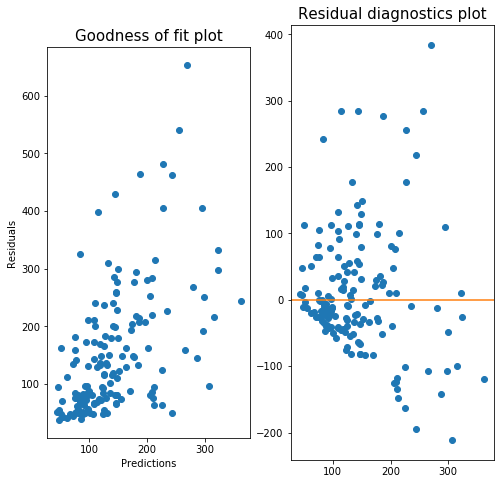

In [30]:
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].scatter(meuse['gp_prediction'], meuse['lead'])
axes[0].set_aspect('equal')
axes[0].set_title('Goodness of fit plot', size=15)
axes[0].set_xlabel('Predictions')
axes[0].set_ylabel('True values')

axes[1].scatter(meuse['gp_prediction'], meuse['gp_residual'])
axes[1].axhline(0, c='C1')
axes[1].set_title('Residual diagnostics plot', size=15)
axes[0].set_xlabel('Predictions')
axes[0].set_ylabel('Residuals')


Text(0.5, 1.0, 'Min max scaled')

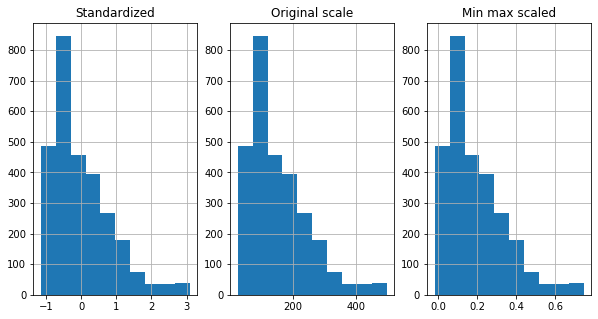

In [31]:
grid_points['gp_prediction_standardized'] = gpr.predict(grid_points[['x', 'y']])
grid_points['gp_prediction'] = standard_scaler.inverse_transform(grid_points[['gp_prediction_standardized']])
grid_points['gp_prediction_normalized'] = minmax_transformer.transform(grid_points[['gp_prediction']])

fig, axes = plt.subplots(1,3, figsize=(10,5))

grid_points['gp_prediction_standardized'].hist(ax=axes[0])
axes[0].set_title('Standardized')

grid_points['gp_prediction'].hist(ax=axes[1])
axes[1].set_title('Original scale')

grid_points['gp_prediction_normalized'].hist(ax=axes[2])
axes[2].set_title('Min max scaled')


In [32]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = 'epsg:28992'
grid_points_gpd = grid_points_gpd.to_crs('epsg:4326')
grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)

grid_points_pivot = grid_points_gpd.pivot(values='gp_prediction_normalized', columns='x', index='y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]

In [33]:
m = folium.Map([meuse['lat'].mean(), meuse['long'].mean()], zoom_start=13, tiles='Stamen Toner')

colormap = plt.get_cmap('winter')

def color_function(x):
    
        color_rgba = colormap(x)
        return color_rgba        

folium.raster_layers.ImageOverlay(
    bounds=[[grid_points_gpd['lat'].min(), grid_points_gpd['long'].min()], 
            [grid_points_gpd['lat'].max(), grid_points_gpd['long'].max()]],
    image=(grid_points_pivot.values),
    origin='lower',
    colormap=lambda x: color_function(x),
    opacity=0.5
).add_to(m)

for i, row in meuse.iterrows():
    color_rgba = colormap(row['lead_normalized'])
    color_hex = matplotlib.colors.rgb2hex(color_rgba)
    folium.CircleMarker(location=[row['lat'], row['long']], 
                        radius=3, 
                        color=None, 
                        fill_opacity=1,
                        fill_color=color_hex).add_to(m)

m

# END OF NOTEBOOK

## Ordinary kriging

Variogram parameters are set with trail and error.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Sill: 13500
Range: 900
Nugget: 4000 



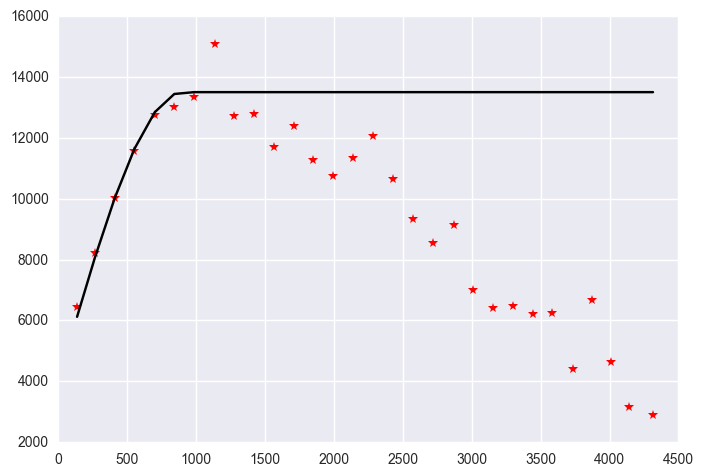

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [6]:
model = OrdinaryKriging(x=meuse_train['x'], y=meuse_train['y'], z=meuse_train['lead'], verbose=True,
                variogram_parameters=[13500, 900, 4000],
                enable_plotting=True, nlags=30, weight=True, variogram_model='spherical')
meuse_train['prediction'] = model.execute(style='points',xpoints=meuse_train['x'], ypoints=meuse_train['y'] )[0].data
meuse_train['kriging_residual'] = meuse_train['lead'] - meuse_train['prediction']
meuse_test['prediction'] = model.execute(style='points', xpoints=meuse_test['x'], ypoints=meuse_test['y'] )[0].data
meuse_test['kriging_residual'] = meuse_test['lead'] - meuse_test['prediction']

## Model performance

- Performance on training data (kriging is an exact interpollator, so perfect prediction)
- Performance on test data

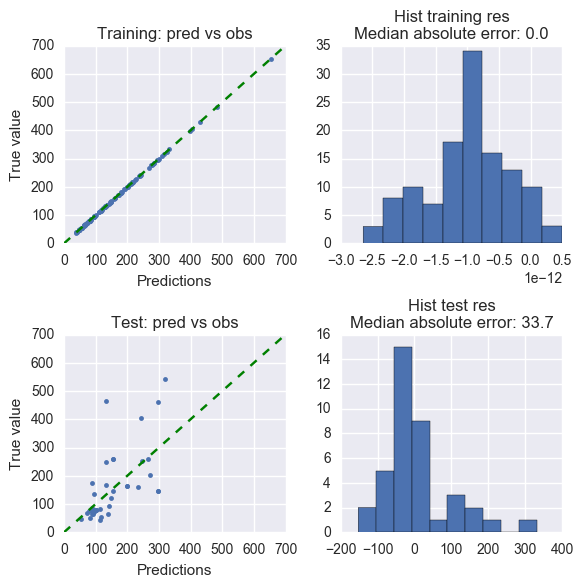

In [7]:
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.plot(meuse_train['prediction'], meuse_train['lead'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0,700], [0,700], 'g--')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(222)
meuse_train['kriging_residual'].hist()
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_train['kriging_residual']))))
plt.subplot(223)
plt.plot(meuse_test['prediction'], meuse_test['lead'], '.')
plt.plot([0,700], [0,700], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(224)
meuse_test['kriging_residual'].hist()
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_test['kriging_residual']))))
plt.tight_layout()

## Benchmark with Nearest Neighbours regression

Optimise number of neighbours with sklearn gridsearch

In [8]:
parameters = {'n_neighbors':np.arange(1,10)}
nn_model = KNeighborsRegressor()
nn_model_cv = GridSearchCV(nn_model, parameters)
nn_model_cv = nn_model_cv.fit(meuse_train[['x', 'y']], meuse_train['lead']) 
print('Optimal number of neighbours {}'.format(nn_model_cv.best_params_))
nn_model = nn_model_cv.best_estimator_
meuse_test['nn_prediction'] = nn_model.predict(meuse_test[['x', 'y']])
meuse_test['nn_residual'] = meuse_test['lead'] - meuse_test['nn_prediction']

Optimal number of neighbours {'n_neighbors': 4}


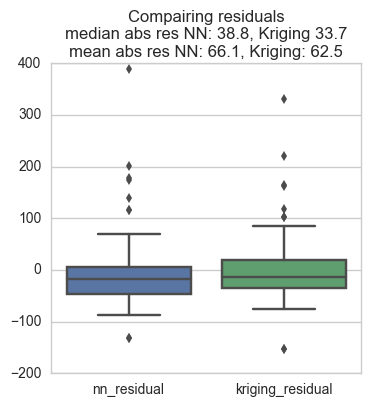

In [9]:
sb.set_style("whitegrid")
plt.figure(figsize=(4,4))
sb.boxplot(data=meuse_test[["nn_residual","kriging_residual"]] )
plt.title('Compairing residuals\nmedian abs res NN: {:.1f}, Kriging {:.1f}\nmean abs res NN: {:.1f}, Kriging: {:.1f}'\
          .format(np.median(np.abs(meuse_test['nn_residual'])), np.median(np.abs(meuse_test['kriging_residual'])),
                 np.mean(np.abs(meuse_test['nn_residual'])), np.mean(np.abs(meuse_test['kriging_residual']))))

In [85]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step


## Sample a grid 

- Find the convex hull surrounding the measurements
- Sample a grid as found with the help functions

Text(0.5, 1.0, 'Sampled grid')

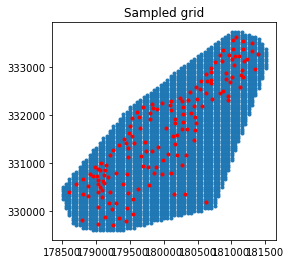

In [208]:
convex_hull = shapely.geometry.MultiPoint(list(meuse.geometry)).convex_hull.buffer(150)
sampler = RegularGridSampler(convex_hull, x_interval=50, y_interval=50)
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(4,4))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(meuse['x'], meuse['y'], 'r.')
plt.title('Sampled grid')

## Krige a value for each grid point

In [209]:
grid_points['prediction'] = model.execute(style='points', xpoints=grid_points['x'], ypoints=grid_points['y'])[0].data

NameError: name 'model' is not defined

## Transform data for a map

- Transform to lat long projection
- From long to wide format
- Fill in missing values

In [13]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = {'init':'epsg:28992'}
grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)

In [14]:
grid_points_pivot = grid_points_gpd.pivot(values='prediction', columns='x', index='y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]

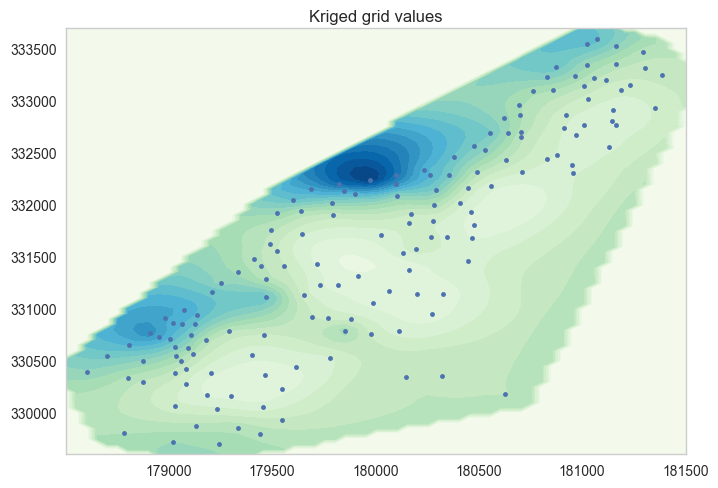

In [15]:
plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
             grid_points_pivot.values/np.nanmax(grid_points_pivot.values),20,cmap='GnBu')
plt.plot(meuse['x'], meuse['y'], '.')
plt.title('Kriged grid values')

## Folium plot

In [16]:
def color_function(value):
    if (value==0) | (value==np.nan) : return (0,0,0,0)
    else: 
        color = matplotlib.cm.YlOrRd(value) 
        return color

In [17]:
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
m.add_children(plugins.ImageOverlay(image = (grid_points_pivot.values/np.nanmax(grid_points_pivot.values)), 
                                           opacity=0.7,origin='lower',
                                           colormap=color_function,
                                   bounds = [[np.min(grid_points_gpd['lat']), np.min(grid_points_gpd['long'])],
                                            [np.max(grid_points_gpd['lat']), np.max(grid_points_gpd['long'])]]))
for row in meuse_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=50, color=None, fill_opacity=1,
                    fill_color=scale(row[1][feature_to_plot])).add_to(m)
m.add_children(scale)